# Import Data

In [66]:
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
import sys
from sqlalchemy import create_engine
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


train_df = pd.read_csv('../Notebooks/kaggle/training_data.csv')
test_df = pd.read_csv('../Notebooks/kaggle/testing_data.csv')

# Split Data

In [67]:

def split_data(X, y, test_size):
    
    return train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Fit and Predict

In [68]:
def fit_and_predict(model, X_train, y_train, X_test):
    model = model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    return prediction

# Calculate Statistics

In [69]:
def calculate_statistics(y_test, pred):
    acurancy = metrics.accuracy_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)
    f1_score1 = metrics.f1_score(y_test, pred)
    aoc = metrics.roc_auc_score(y_test, pred)
    log_loss = metrics.log_loss(y_test, pred)
    
    print(f"Acurancy: {acurancy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score1}")
    print(f"AOC: {aoc}")
    print(f"Log Loss: {log_loss}")

# Resampling

In [70]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def apply_sampling(model):
    smote = SMOTE(random_state=42)

    pipeline = Pipeline([('smote', smote), ('model', model)])

    return pipeline

def grid_search(model, X_train, y_train,X_test,y_test, parameter_grid):
    stratifiedKFold = StratifiedKFold(n_splits=5)
    pipe = apply_sampling(model)
    grid = GridSearchCV(pipe, param_grid=parameter_grid, cv=stratifiedKFold, scoring='roc_auc',verbose=4, n_jobs=-1,refit=True)

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_score = grid.best_score_
    best_model_pred = best_model.predict(X_test)
    best_model_pred_proba = best_model.predict_proba(X_test)[:,1]

    print("AUC SCORE: ", metrics.roc_auc_score(y_test, best_model_pred_proba))
    print("Confusion Matrix: ", confusion_matrix(y_test, best_model_pred))
    print("Best Score: ", best_score)
    print("Best Parameters: ", grid.best_params_)
    print("Best Estimator: ", grid.best_estimator_)
    print("Best Model: ", best_model)
    print("Classification report:", metrics.classification_report(y_test, best_model_pred))
    metrics.plot_roc_curve(best_model, X_test, y_test)
    plt.show()

    return best_model

# Feature Selection

In [71]:
from sklearn.feature_selection import SequentialFeatureSelector, RFECV, SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
def fs_rfecv(x, y, n_features):
    rfecv = RFECV(estimator=RandomForestClassifier(random_state=0),
                                                    min_features_to_select=n_features,
                                                    cv=5,
                                                    scoring='roc_auc',
                                                    n_jobs=-1)
    rfecv.fit(x, y)

    best_features = list(x.columns[rfecv.support_])

    print('\n> Recursive feature elimination')
    print('Optimal number of features :', rfecv.n_features_)
    print('Best features :', best_features)

    return best_features
def fs_kbest(x, y, n_features):
    kbest = SelectKBest(f_classif, k=n_features)
    kbest.fit(x, y)

    best_features = list(x.columns[kbest.get_support()])

    print('\n> KBest')
    print('Best features :', best_features)

    return best_features
save_features = list(train_df.columns)
save_features.remove('loan_id')
save_features.remove('loan_status')
features = fs_rfecv(train_df[save_features], train_df['loan_status'], 19)
features.append('loan_id')
features.append('loan_status')



> KBest
Best features : ['loan_amount', 'loan_payments', 'region', 'criminal growth', 'unemploymant growth', 'enterpreuners ratio', 'age on loan', 'account age at loan', 'trans_type_mean_credit', 'trans_amount_mean', 'trans_amount_std', 'trans_amount_last', 'trans_balance_mean', 'trans_balance_min', 'trans_balance_std', 'trans_balance_last', 'negative_balance', 'months_until_bankrupt', 'ops_per_month']


# Confusion Matrix

In [72]:
def display_conf_matrix_graph(y_test, pred):
    conf_matrix = confusion_matrix(y_test, pred)
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Not Paid", "Paid"])
    cm_display.plot()

# Decision Tree

Fitting 5 folds for each of 56 candidates, totalling 280 fits
AUC SCORE:  0.5655864197530864
Confusion Matrix:  [[ 5  7]
 [ 7 47]]
Best Score:  0.7499102829537612
Best Parameters:  {'model__criterion': 'gini', 'model__max_depth': 6, 'model__splitter': 'best'}
Best Estimator:  Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model', DecisionTreeClassifier(max_depth=6))])
Best Model:  Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model', DecisionTreeClassifier(max_depth=6))])
Classification report:               precision    recall  f1-score   support

          -1       0.42      0.42      0.42        12
           1       0.87      0.87      0.87        54

    accuracy                           0.79        66
   macro avg       0.64      0.64      0.64        66
weighted avg       0.79      0.79      0.79        66



C:\Users\Viper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


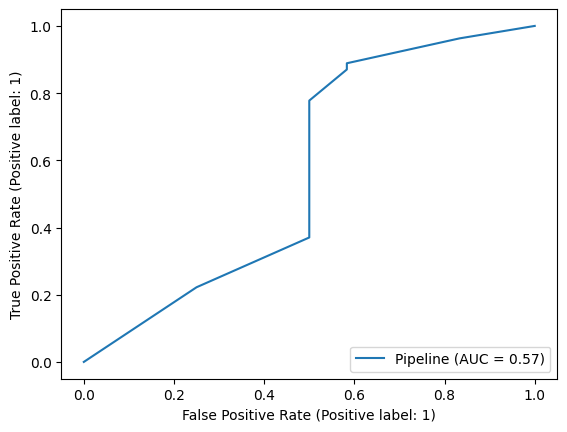

In [73]:
#import decision tree classifier from sklearn
from sklearn.tree import DecisionTreeClassifier
# features = [x for x in train_df.columns if x not in ['loan_status']]
# X = train_df[features]
# y = train_df['loan_status']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


# dTree = DecisionTreeClassifier()
# pipeline = apply_sampling(dTree)
# dTree_pred = fit_and_predict(dTree, X_train, y_train, X_test)

# calculate_statistics(y_test, dTree_pred)
# display_conf_matrix_graph(y_test, dTree_pred)

#dtree with grid search
features = [x for x in train_df.columns if x not in ['loan_status']]
X = train_df[features]
y = train_df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
dTree = DecisionTreeClassifier()
parameter_grid = {'model__criterion': ['gini', 'entropy'],'model__splitter': ['best', 'random'],'model__max_depth': range(1,15)}
dTree = grid_search(dTree, X_train, y_train,X_test,y_test, parameter_grid)



# Random Forest

Fitting 5 folds for each of 24 candidates, totalling 120 fits
AUC SCORE:  0.8653846153846154
Confusion Matrix:  [[ 3  5]
 [ 9 82]]
Best Score:  0.8752964141122035
Best Parameters:  {'model__criterion': 'gini', 'model__max_depth': 15, 'model__n_estimators': 200, 'model__n_jobs': -1}
Best Estimator:  Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=15, n_estimators=200,
                                        n_jobs=-1))])
Best Model:  Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=15, n_estimators=200,
                                        n_jobs=-1))])
Classification report:               precision    recall  f1-score   support

          -1       0.25      0.38      0.30         8
           1       0.94      0.90      0.92        91

    accuracy                           0.86        99
   macro avg       0.60      0.64      0

C:\Users\Viper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


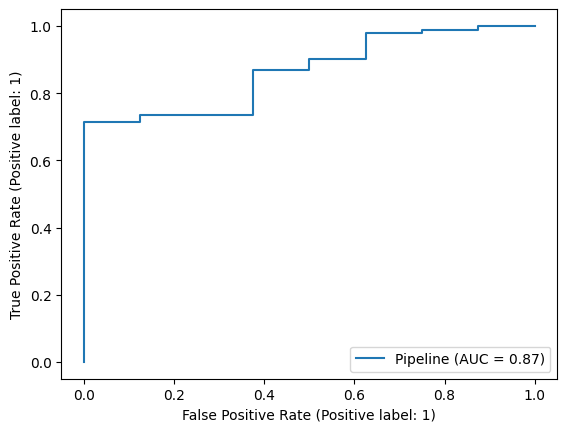

In [74]:
from sklearn.ensemble import RandomForestClassifier
#features = [x for x in train_df.columns if x not in ['loan_status']]
X = train_df[features]
y = train_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

rf = RandomForestClassifier()
parameter_grid = {'model__n_estimators': [10, 50, 100, 200], 'model__max_depth': [5, 10, 15], 'model__n_jobs': [-1], 'model__criterion': ['gini', 'entropy']}
rf = grid_search(rf, X_train, y_train,X_test,y_test, parameter_grid)

# Logistic Regretion

Fitting 5 folds for each of 3 candidates, totalling 15 fits
AUC SCORE:  0.6510989010989011
Confusion Matrix:  [[ 3  5]
 [40 51]]
Best Score:  0.7889941199151727
Best Parameters:  {'model__max_iter': 10000, 'model__solver': 'lbfgs'}
Best Estimator:  Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=10000))])
Best Model:  Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=10000))])
Classification report:               precision    recall  f1-score   support

          -1       0.07      0.38      0.12         8
           1       0.91      0.56      0.69        91

    accuracy                           0.55        99
   macro avg       0.49      0.47      0.41        99
weighted avg       0.84      0.55      0.65        99



C:\Users\Viper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


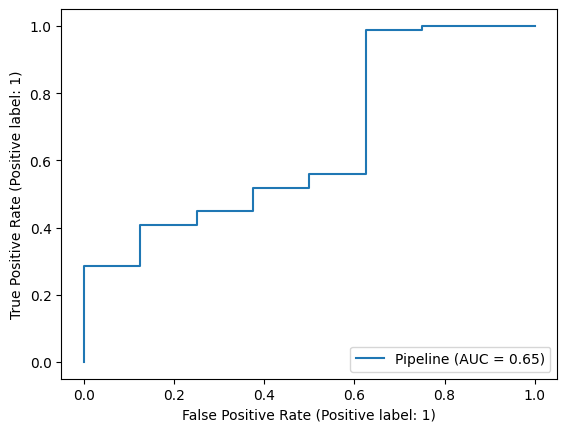

In [75]:
from sklearn.linear_model import LogisticRegression
features = [x for x in train_df.columns if x not in ['loan_status']]
X = train_df[features]
y = train_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

lr = LogisticRegression()
parameter_grid = {'model__max_iter': [1000, 5000, 10000], 'model__solver': ['lbfgs']}
lr = grid_search(lr, X_train, y_train,X_test,y_test, parameter_grid)

# Naive Bays

Fitting 5 folds for each of 5 candidates, totalling 25 fits
AUC SCORE:  0.6662087912087912
Confusion Matrix:  [[ 3  5]
 [16 75]]
Best Score:  0.6482793522267206
Best Parameters:  {'model__var_smoothing': 1e-05}
Best Estimator:  Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model', GaussianNB(var_smoothing=1e-05))])
Best Model:  Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model', GaussianNB(var_smoothing=1e-05))])
Classification report:               precision    recall  f1-score   support

          -1       0.16      0.38      0.22         8
           1       0.94      0.82      0.88        91

    accuracy                           0.79        99
   macro avg       0.55      0.60      0.55        99
weighted avg       0.87      0.79      0.82        99



C:\Users\Viper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


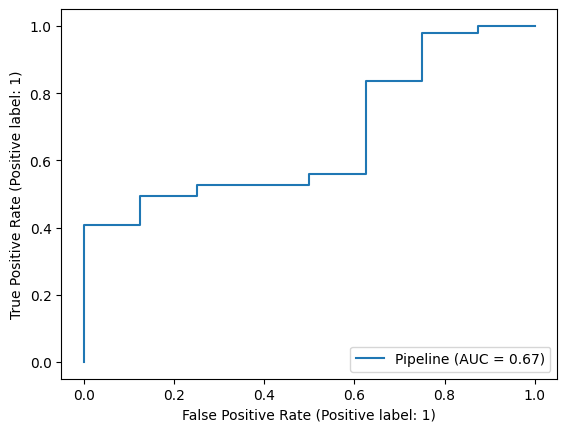

In [76]:
from sklearn.naive_bayes import GaussianNB
features = [x for x in train_df.columns if x not in ['loan_status']]
X = train_df[features]
y = train_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

nb = GaussianNB()
parameter_grid = {'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
nb = grid_search(nb, X_train, y_train,X_test,y_test, parameter_grid)

# K-Nearest Neighbors

Fitting 5 folds for each of 36 candidates, totalling 180 fits
AUC SCORE:  0.8454670329670331
Confusion Matrix:  [[ 7  1]
 [33 58]]
Best Score:  0.7681933198380566
Best Parameters:  {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_jobs': -1, 'model__n_neighbors': 15}
Best Estimator:  Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 KNeighborsClassifier(leaf_size=5, n_jobs=-1, n_neighbors=15))])
Best Model:  Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 KNeighborsClassifier(leaf_size=5, n_jobs=-1, n_neighbors=15))])
Classification report:               precision    recall  f1-score   support

          -1       0.17      0.88      0.29         8
           1       0.98      0.64      0.77        91

    accuracy                           0.66        99
   macro avg       0.58      0.76      0.53        99
weighted avg       0.92      0.66      0.73        99



C:\Users\Viper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


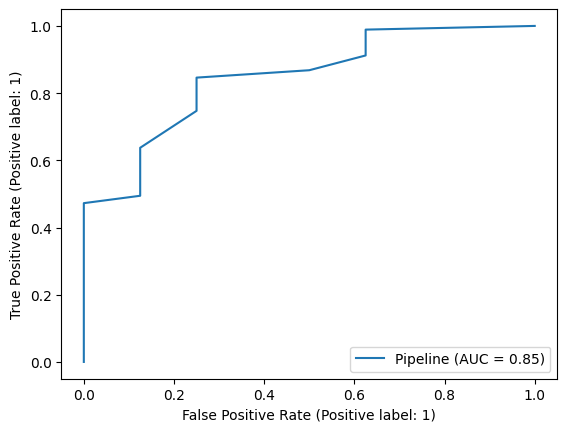

In [77]:
#import knn classifier from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
knn = KNeighborsClassifier()

features = [x for x in train_df.columns if x not in ['loan_status']]
X = train_df[features]
y = train_df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


parameter_grid = {'model__n_neighbors': [4, 5, 6, 7, 10, 15],
                  'model__leaf_size': [5, 10, 15, 20, 50, 100],
                  'model__n_jobs': [-1],
                  'model__algorithm': ['auto']}
knn = grid_search(knn, X_train, y_train,X_test,y_test, parameter_grid)

# SVM

In [78]:
# #import svm
# from sklearn.svm import SVC

# features = [x for x in train_df.columns if x not in ['loan_status']]
# X = train_df[features]
# y = train_df['loan_status']

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# svm = SVC(random_state=42, probability=True)
# parameter_grid = {'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'model__C' : [1,10,50], 'model__gamma': [0.001,0.0001]}
# svm = grid_search(svm, X_train, y_train,X_test,y_test, parameter_grid)


# Kaggle Submission

In [79]:
comp_X = test_df[features]

prediction = pd.DataFrame(rf.predict_proba(comp_X))
submission = pd.DataFrame({'Id': test_df['loan_id'], 'Predicted': prediction[0]})
submission.to_csv('results.csv', columns=['Id', 'Predicted'], index=False)